In [66]:
# Inside-Out Transformer (PyTorch)
# - forward(idx, targets=None) -> (y, loss)  # loss=None when targets is None
# - anchors define a "shell" (frame); model reasons in residual space outside that shell

import math
import torch
import torch.nn as nn
import torch.nn.functional as F

# ------------------------------------------------------------
# Utils
# ------------------------------------------------------------
def _init_trunc_normal_(w, std=0.02):
    # Truncated normal initializer like transformer defaults
    nn.init.trunc_normal_(w, std=std, a=-2*std, b=2*std)

def rms_norm(x, eps=1e-6):
    return x * torch.rsqrt(x.pow(2).mean(dim=-1, keepdim=True) + eps)

# ------------------------------------------------------------
# Anchor Field: soft nearest anchor & residual (outside component)
# ------------------------------------------------------------
class AnchorField(nn.Module):
    def __init__(self, embed, d_model, n_anchors=64, beta=1.5):
        super().__init__()
        self.anchors = embed.weight
        self.beta = beta  # temperature for soft assignment

    def forward(self, h):
        """
        h: (B, T, d)
        returns:
          r: residual outside component (B, T, d)
          u: normalized outward normals (B, T, d)
          h_anchor: soft anchor reconstruction (B, T, d)
          w: soft assignments (B, T, n_anchors)
        """
        B, T, d = h.shape
        A = F.normalize(self.anchors, dim=-1)  # (A, d)
        h_n = F.normalize(h, dim=-1)          # normalize for similarity
        # similarities (B, T, A)
        sim = torch.einsum("btd,ad->bta", h_n, A)
        w = F.softmax(self.beta * sim, dim=-1)  # soft nearest anchor weights
        h_anchor = torch.einsum("bta,ad->btd", w, A)  # back into d-space (on anchor shell)
        # residual outside shell
        r = h - h_anchor
        u = F.normalize(r, dim=-1)  # outward normal direction
        return r, u, h_anchor, w

# ------------------------------------------------------------
# Attention with "outside" coherence penalty
# ------------------------------------------------------------
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

# -------------------------------
# Relative Position Bias (T5 style)
# -------------------------------
class RelativePositionBiasT5(nn.Module):
    def __init__(self, n_head, num_buckets=32, max_distance=128):
        super().__init__()
        self.n_head = n_head
        self.num_buckets = num_buckets
        self.max_distance = max_distance
        self.bias = nn.Parameter(torch.zeros(n_head, num_buckets))
        nn.init.zeros_(self.bias)

    def _relative_position_bucket(self, relative_positions):
        # relative_positions: (T, T) with values j - i
        ret = torch.zeros_like(relative_positions)
        n = -relative_positions  # we want distances into the past to be >= 0
        # exact for small |n|
        max_exact = self.num_buckets // 2
        is_small = n < max_exact
        ret = torch.where(is_small, n, ret)
        # logarithmic buckets for larger distances
        val_if_large = max_exact + (
            (torch.log(n.float() / max_exact) /
             math.log(self.max_distance / max_exact)) *
            (self.num_buckets - max_exact)
        ).to(torch.long)
        val_if_large = torch.clamp(val_if_large, max=max_exact + (self.num_buckets - max_exact) - 1)
        ret = torch.where(is_small, ret, val_if_large)
        ret = torch.clamp(ret, min=0, max=self.num_buckets - 1)
        return ret  # (T,T) in [0, num_buckets)

    def forward(self, T, device):
        pos = torch.arange(T, device=device)
        rel = pos[None, :] - pos[:, None]  # (T, T) = j - i
        buckets = self._relative_position_bucket(rel)  # (T,T)
        # (H, T, T)
        out = self.bias[:, buckets]  # fancy indexing broadcasts over (T,T)
        return out.unsqueeze(0)  # (1, H, T, T)

# -------------------------------
# ALiBi linear distance bias
# -------------------------------
def _alibi_slopes(n):
    # standard ALiBi head slopes
    def get_slopes(n):
        start = 2 ** (-2 ** -(math.log2(n) - 3))
        ratio = start
        return [start * (ratio ** i) for i in range(n)]
    if math.log2(n).is_integer():
        return torch.tensor(get_slopes(n))
    # interpolate if n not power of 2
    closest_pow2 = 2 ** math.floor(math.log2(n))
    slopes = get_slopes(closest_pow2)
    extra = get_slopes(2 * closest_pow2)[0::2]
    slopes = slopes + extra[: n - closest_pow2]
    return torch.tensor(slopes)

class ALiBiBias(nn.Module):
    def __init__(self, n_head):
        super().__init__()
        self.register_buffer("slopes", _alibi_slopes(n_head).view(n_head, 1, 1), persistent=False)

    def forward(self, T, device):
        pos = torch.arange(T, device=device)
        rel = pos[None, :] - pos[:, None]  # (T, T) = j - i
        bias = -self.slopes * rel.abs()[None, None, :, :]  # (1,H,T,T)
        return bias

# -------------------------------
# Directional Wedge Bias (antisymmetric, content-aware)
# uses outward normals u from your AnchorField
# -------------------------------
class DirectionalWedgeBias(nn.Module):
    def __init__(self, d_model, n_head, gamma=0.15):
        super().__init__()
        assert d_model % n_head == 0
        self.n_head = n_head
        self.d_head = d_model // n_head
        # A --> S = A - A^T ensures skew-symmetry per head
        self.A = nn.Parameter(torch.zeros(n_head, self.d_head, self.d_head))
        nn.init.trunc_normal_(self.A, std=0.02, a=-0.04, b=0.04)
        # positive distance scale per head (for exponential decay)
        self.log_tau = nn.Parameter(torch.zeros(n_head))  # tau = softplus(log_tau) + eps
        self.gamma = gamma

    def forward(self, u, T):
        """
        u: (B, T, d_model) outward normals
        returns: (B, H, T, T) bias to add to attention logits
        """
        B, T_, D = u.shape
        assert T_ == T
        H, Dh = self.n_head, self.d_head

        # per-head normals
        u_h = u.view(B, T, H, Dh).transpose(1, 2)  # (B, H, T, Dh)

        # skew-symmetric form S
        S = self.A - self.A.transpose(-1, -2)      # (H, Dh, Dh)

        # wedge score: u_i^T S u_j (antisymmetric => directional)
        # (B,H,T,Dh) x (H,Dh,Dh) x (B,H,T,Dh) -> (B,H,T,T)
        tmp = torch.einsum("bhtd,hde->bhte", u_h, S)     # (B,H,T,Dh)
        wedge = torch.einsum("bhte,bhse->bhts", tmp, u_h)  # (B,H,T,T)

        # distance-based decay (learned per head)
        tau = F.softplus(self.log_tau).view(1, H, 1, 1) + 1e-4
        pos = torch.arange(T, device=u.device)
        dist = (pos[None, :] - pos[:, None]).abs().view(1, 1, T, T)  # (1,1,T,T)
        decay = torch.exp(-dist / tau)  # (1,H,T,T)

        return self.gamma * wedge * decay  # (B,H,T,T)

# -------------------------------
# Patched AnchorAttention with pluggable bias
# -------------------------------
class AnchorAttention(nn.Module):
    def __init__(
        self,
        d_model,
        n_head,
        dropout=0.0,
        lambda_normal=0.15,
        pos_bias: nn.Module = None,   # e.g., RelativePositionBiasT5 / ALiBiBias / DirectionalWedgeBias
        use_wedge_with_u: bool = True
    ):
        super().__init__()
        assert d_model % n_head == 0
        self.n_head = n_head
        self.d_head = d_model // n_head
        self.q_proj = nn.Linear(d_model, d_model, bias=False)
        self.k_proj = nn.Linear(d_model, d_model, bias=False)
        self.v_proj = nn.Linear(d_model, d_model, bias=False)
        self.o_proj = nn.Linear(d_model, d_model, bias=False)
        self.dropout = nn.Dropout(dropout)
        self.lambda_normal = lambda_normal
        self.pos_bias = pos_bias
        self.use_wedge_with_u = use_wedge_with_u  # True only for DirectionalWedgeBias

        for p in self.parameters():
            if p.dim() > 1:
                nn.init.trunc_normal_(p, std=0.02, a=-0.04, b=0.04)

    def forward(self, r, u, attn_mask=None):
        B, T, D = r.shape
        H, Dh = self.n_head, self.d_head

        q = self.q_proj(r).view(B, T, H, Dh).transpose(1, 2)  # (B,H,T,Dh)
        k = self.k_proj(r).view(B, T, H, Dh).transpose(1, 2)
        v = self.v_proj(r).view(B, T, H, Dh).transpose(1, 2)

        att = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(Dh)  # (B,H,T,T)

        # outward-normal coherence penalty (your original idea)
        u_h = u.view(B, T, H, Dh).transpose(1, 2)  # (B,H,T,Dh)
        norm_sim = torch.matmul(u_h, u_h.transpose(-2, -1))
        att = att - self.lambda_normal * (1.0 - norm_sim)

        # --- Positional bias inside attention ---
        if self.pos_bias is not None:
            if self.use_wedge_with_u:
                # content-aware directional term
                att = att + self.pos_bias(u, T)  # (B,H,T,T)
            else:
                # relative bias that depends only on (i,j)
                bias = self.pos_bias(T, device=r.device)  # (1,H,T,T)
                att = att + bias

        if attn_mask is not None:
            att = att.masked_fill(attn_mask == 0, float("-inf"))

        w = F.softmax(att, dim=-1)
        w = self.dropout(w)
        out = torch.matmul(w, v)  # (B,H,T,Dh)
        out = out.transpose(1, 2).contiguous().view(B, T, D)
        out = self.o_proj(out)
        return out

# ------------------------------------------------------------
# Feedforward on residual; then re-anchor (residual -> delta_h)
# ------------------------------------------------------------
class ReanchorMLP(nn.Module):
    def __init__(self, d_model, d_ff=4_096, dropout=0.0):
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_ff, bias=False)
        self.fc2 = nn.Linear(d_ff, d_model, bias=False)
        self.dropout = nn.Dropout(dropout)
        for p in self.parameters():
            if p.dim() > 1:
                _init_trunc_normal_(p)

    def forward(self, r):
        x = self.fc1(r)
        x = F.gelu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# ------------------------------------------------------------
# Block: normalize -> anchor residual -> attn -> mlp, all in outside space
# ------------------------------------------------------------
class InsideOutBlock(nn.Module):
    def __init__(self, d_model, n_head, anchor_field, d_ff=4_096, dropout=0.0, lambda_normal=0.15):
        super().__init__()
        self.anchor_field = anchor_field  # shared across blocks
        self.norm1 = nn.LayerNorm(d_model, elementwise_affine=True)
        self.norm2 = nn.LayerNorm(d_model, elementwise_affine=True)
        self.pos_bias = DirectionalWedgeBias(d_model, n_head, gamma=0.1)
        self.attn = AnchorAttention(d_model, n_head, dropout=dropout, pos_bias = self.pos_bias, lambda_normal=lambda_normal)
        self.mlp = ReanchorMLP(d_model, d_ff=d_ff, dropout=dropout)
        self.drop = nn.Dropout(dropout)

    def forward(self, h, attn_mask=None):
        # 1) compute residual outside the anchor shell
        x = self.norm1(h)
        r, u, _, _ = self.anchor_field(x)  # (B,T,d), (B,T,d)
        # 2) anchored attention over residuals
        a = self.attn(r, u, attn_mask=attn_mask)
        h = h + self.drop(a)  # re-integrate into running state
        # 3) re-anchoring MLP acts on the current outside residual again
        x = self.norm2(h)
        r2, _, _, _ = self.anchor_field(x)
        m = self.mlp(r2)
        h = h + self.drop(m)
        # we return both h and the latest residual r2 for auxiliary losses
        return h, r2

# ------------------------------------------------------------
# Full Model
# ------------------------------------------------------------
class InsideOutTransformer(nn.Module):
    def __init__(
        self,
        vocab_size,
        d_model=768,
        n_layer=6,
        n_head=12,
        d_ff=3072,
        n_anchors=64,
        beta=1.5,
        dropout=0.1,
        lambda_normal=0.15,
        radius_target=1.0,
        radius_coef=0.01,
        smooth_coef=0.005,
        max_seq_len=512
    ):
        super().__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.max_seq_len = max_seq_len

        self.tok_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = nn.Embedding(max_seq_len, d_model)

        self.anchor_field = AnchorField(self.tok_emb, d_model, n_anchors=n_anchors, beta=beta)
        self.blocks = nn.ModuleList([
            InsideOutBlock(
                d_model, n_head, self.anchor_field,
                d_ff=d_ff, dropout=dropout, lambda_normal=lambda_normal
            ) for _ in range(n_layer)
        ])
        self.norm_f = nn.LayerNorm(d_model)
        self.lm_head = nn.Linear(d_model, vocab_size, bias=False)

        # Loss shaping
        self.radius_target = radius_target
        self.radius_coef = radius_coef
        self.smooth_coef = smooth_coef

        self.apply(self._init_params)

    def _init_params(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            _init_trunc_normal_(module.weight)
        if isinstance(module, nn.Linear) and module.bias is not None:
            nn.init.zeros_(module.bias)

    def forward(self, idx, targets=None):
        """
        idx: LongTensor (B, T)
        targets: LongTensor (B, T) or None
        returns: (y, loss) where y = logits (B, T, vocab), loss=None if targets is None
        """
        B, T = idx.shape
        device = idx.device

        h = self.tok_emb(idx) 
        # causal mask
        mask = torch.tril(torch.ones(T, T, device=device, dtype=torch.bool))
        attn_mask = mask.unsqueeze(0).unsqueeze(0)  # (1,1,T,T) for broadcasting

        # pass through blocks
        residuals = []
        for blk in self.blocks:
            h, r = blk(h, attn_mask=attn_mask)
            residuals.append(r)

        h = self.norm_f(h)
        y = self.lm_head(h)  # logits

        loss = None
        if targets is not None:
            # next-token cross-entropy
            ce = F.cross_entropy(y.view(-1, self.vocab_size), targets.view(-1), ignore_index=-100)

            # radius regularizer: encourage residual norm near radius_target (outside shell)
            # use final block residual for stability
            r_last = residuals[-1]  # (B, T, d)
            r_norm = r_last.norm(dim=-1)  # (B, T)
            radius_loss = ((r_norm - self.radius_target) ** 2).mean()

            # smoothness over time (encourage coherent deformation trajectory)
            if T > 1:
                smooth_loss = (r_last[:, 1:, :] - r_last[:, :-1, :]).pow(2).mean()
            else:
                smooth_loss = torch.zeros((), device=device)

            loss = ce + self.radius_coef * radius_loss + self.smooth_coef * smooth_loss

        return y, loss



In [2]:
import requests, os

base_url = "https://huggingface.co/datasets/cambridge-climb/BabyLM/resolve/main/clean/10M/"
target_dir = "./babylm_10m_cleaned"
os.makedirs(target_dir, exist_ok=True)

file_names = [
    "aochildes.txt",
    "cbt.txt",
    "children_stories.txt",
    "gutenberg.txt",
    "qed.txt",
    "simple_wikipedia.txt",
    "switchboard.txt",
    "wikipedia.txt"
]

# Optional addition: Shakespeare from another dataset
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/refs/heads/master/data/tinyshakespeare/input.txt"
shakespeare_fname = "shakespeare.txt"

# Combined download logic
all_files = [(base_url + fname, fname) for fname in file_names]
all_files.append((shakespeare_url, shakespeare_fname))  # Add Shakespeare


# Download loop
for url, fname in all_files:
    out_path = os.path.join(target_dir, fname)
    print(f"📥 Downloading {fname}...")
    resp = requests.get(url)
    if resp.status_code == 200:
        with open(out_path, "w", encoding="utf-8") as f:
            f.write(resp.text)
    else:
        print(f"❌ Failed to download {fname} ({resp.status_code})")

print(f"✅ Done. Files saved to {target_dir}")

📥 Downloading aochildes.txt...
📥 Downloading cbt.txt...
📥 Downloading children_stories.txt...
📥 Downloading gutenberg.txt...
📥 Downloading qed.txt...
📥 Downloading simple_wikipedia.txt...
📥 Downloading switchboard.txt...
📥 Downloading wikipedia.txt...
📥 Downloading shakespeare.txt...
✅ Done. Files saved to ./babylm_10m_cleaned


In [33]:
import os
import pickle
import numpy as np

# === Paths ===
source_dir = "./babylm_10m_cleaned"
out_dir    = "./babylm_char_tokenized"
os.makedirs(out_dir, exist_ok=True)

file_names = [
    "shakespeare.txt"#,"aochildes.txt", "cbt.txt", "children_stories.txt", "gutenberg.txt",
    #"qed.txt", "simple_wikipedia.txt", "switchboard.txt", "wikipedia.txt"
]

# === Load and split ===
train_texts, val_texts = [], []
char_set = set()

for fname in file_names:
    with open(os.path.join(source_dir, fname), encoding="utf-8") as f:
        lines = f.readlines()
        n = len(lines)
        split = int(0.9 * n)
        train_part = "".join(lines[:split])
        val_part   = "".join(lines[split:])
        train_texts.append(train_part)
        val_texts.append(val_part)
        char_set.update(train_part)
        char_set.update(val_part)

full_train = "\n".join(train_texts)
full_val   = "\n".join(val_texts)

# === Final vocab ===
char_set = sorted(set(char_set))
vocab_chars = ["<unk>"] + [c for c in char_set if c != "<unk>"]

stoi = {ch: i for i, ch in enumerate(vocab_chars)}
itos = {i: ch for ch, i in stoi.items()}

# === Encode function ===
def encode(text):
    return [stoi.get(c, 0) for c in text]

train_ids = np.array(encode(full_train), dtype=np.uint16)
val_ids   = np.array(encode(full_val),   dtype=np.uint16)

# === Save ===
train_ids.tofile(os.path.join(out_dir, "train.bin"))
val_ids.tofile(os.path.join(out_dir, "val.bin"))

with open(os.path.join(out_dir, "meta.pkl"), "wb") as f:
    pickle.dump({
        "vocab_size": len(stoi),
        "stoi": stoi,
        "itos": itos
    }, f)

print(f"✅ Char tokenizer finalized.")
print(f"🧾 Train tokens: {len(train_ids)} | Val tokens: {len(val_ids)}")
print(f"🔤 Vocab size: {len(stoi)}")

✅ Char tokenizer finalized.
🧾 Train tokens: 1016242 | Val tokens: 99152
🔤 Vocab size: 66


In [70]:
import os
import pickle
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torch
from torch import nn
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"

# === Config ===
data_dir = "./babylm_char_tokenized"  # <- char-tokenized data
block_size = 1024
batch_size = 8

# === Load tokenizer metadata ===
with open(os.path.join(data_dir, 'meta.pkl'), 'rb') as f:
    meta = pickle.load(f)
vocab_size = meta['vocab_size']

# === Load mmap data (char-level tokens, uint16) ===
train_ids = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')
val_ids   = np.memmap(os.path.join(data_dir, 'val.bin'),   dtype=np.uint16, mode='r')

# === Efficient GPU Batch Sampler ===
class GPUBatchDataset(Dataset):
    def __init__(self, mmap_file, block_size, batch_size, device, jitter=63, p_aligned=0.5, pad_len=0):
        self.data = mmap_file
        self.block_size = block_size
        self.batch_size = batch_size
        self.device = device
        self.pad_len = int(pad_len)
        self.sample_len = self.block_size + self.pad_len  # X length
        self.total = len(self.data) - self.sample_len - 1
        self.n_blocks = self.total // self.sample_len
        self.jitter = int(jitter)          # small random offset added to aligned start
        self.p_aligned = float(p_aligned)  # mix aligned and jittered

    def __len__(self):
        return self.total // self.batch_size

    def __getitem__(self, idx):
        X = np.empty((self.batch_size, self.sample_len), dtype=np.int64)
        Y = np.empty((self.batch_size, self.block_size), dtype=np.int64)

        for i in range(self.batch_size):
            # choose a base aligned block
            base_block = np.random.randint(0, self.n_blocks)
            start = base_block * self.sample_len

            # with probability, add a small jitter (keeps cache-friendly contiguous reads)
            if np.random.rand() > self.p_aligned:
                j = np.random.randint(0, self.jitter + 1)
                start = min(start + j, self.total)  # stay in range

            X[i] = self.data[start : start + self.sample_len]
            # targets correspond to the final block_size visible steps
            Y[i] = self.data[start + 1 + self.pad_len : start + 1 + self.pad_len + self.block_size]


        return (
            torch.from_numpy(X).to(self.device, non_blocking=True),
            torch.from_numpy(Y).to(self.device, non_blocking=True)
        )



# ------------------------------------------------------------
# Minimal usage demo (random data). Remove/replace with your dataloader.
# ------------------------------------------------------------


model = InsideOutTransformer(
        vocab_size=vocab_size,
        d_model=256,
        n_layer=4,
        n_head=8,
        d_ff=1536,
        n_anchors=vocab_size,
        beta=1.5,
        dropout=0.1,
        lambda_normal=0.12,
        radius_target=1.0,
        radius_coef=0.001,
        smooth_coef=0.001,
        max_seq_len=1024
    )
train_dataset = GPUBatchDataset(train_ids, block_size, batch_size, device, pad_len=0)
# === DataLoader ===
train_loader  = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=0)



model = model.to(device)



In [71]:
#print model params
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 4527648


In [72]:
losses = []
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3)
def train_epoch():
    model.train()
    total_loss = 0

    for xb, yb in train_loader:
          xb, yb = xb[0], yb[0]  # unwrap batch dimension
          optimizer.zero_grad()

          logits, loss = model(xb, yb)
          loss = loss
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
          optimizer.step()
          total_loss += loss.item()
          losses.append(loss.item())
          print(loss.item())
    return total_loss / len(train_loader)

# === Run Training ===
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train_loss = train_epoch()
    print(f"Epoch {epoch:2d} | Train loss: {train_loss:.4f}")

4.422083854675293
3.9418091773986816
3.6274423599243164
3.615840435028076
3.522970676422119
3.569187641143799
3.52765154838562
3.5115671157836914
3.5382471084594727
3.4779574871063232
3.7278878688812256
3.4026851654052734
3.427635908126831
3.421347141265869
3.3736252784729004
3.332937717437744
3.346562623977661
3.3639066219329834
3.4010114669799805
3.307645559310913
3.3708584308624268
3.372682571411133
3.264906406402588
3.3233327865600586
3.2974865436553955
3.3058507442474365
3.306878089904785
3.2516214847564697
3.1989052295684814
3.261789321899414
3.215341806411743
3.1920087337493896
3.192178964614868
3.1394267082214355
3.207873821258545
3.1069936752319336
3.0858731269836426
3.119356155395508
3.1753933429718018
3.1025476455688477
3.0819098949432373
3.0805373191833496
3.063826560974121
3.0205416679382324
3.021831512451172
3.0299031734466553
3.0050086975097656
3.0146074295043945
2.9894821643829346
2.9897611141204834
2.9437530040740967
2.976099729537964
2.924278497695923
2.95094609260559

KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn.functional as F

def expected_rank_of_token(scores: torch.Tensor,
                           token_ids: torch.Tensor,
                           temperature: float = 1.0) -> torch.Tensor:
    """
    Computes the expected rank of the given token at each position, without full V x V matrix.
    """
    # scores: (..., V), token_ids: (...,)

    # Gather score of the target token
    score_i = scores.gather(-1, token_ids.unsqueeze(-1))  # (..., 1)

    # Δ_j = score_j - score_i
    diff = scores - score_i  # (..., V)

    # P(j beats i)
    p = torch.sigmoid(diff / temperature)

    # Expected rank = 1 + sum_j P(j > i)
    return 1.0 + p.sum(dim=-1)  # (...,)


def rank_future_sequence_loss_soft(
    logits: torch.Tensor,
    targets: torch.Tensor,
    max_future_steps: int = 15,
    decay: float = 0.5,
    temperature: float = 1.0,
    reduction: str = "mean",
):
    """
    Memory-efficient smooth rank loss. For each t, matches rank of x_{t+Δ} to Δ.
    logits  … (B, T, V) – model scores
    targets … (B, T)    – token ids
    """
    B, T, V = logits.shape
    device = logits.device
    total_loss = torch.tensor(0.0, device=device)

    for Δ in range(2, max_future_steps + 1):
        if Δ >= T:
            break

        # Current time-step logits (for rank eval)
        cur_logits  = logits[:, :-Δ, :]          # (B, T−Δ, V)
        fut_targets = targets[:, Δ:]             # (B, T−Δ)

        # Efficient rank of ground-truth future token
        tgt_exp_rank = expected_rank_of_token(cur_logits, fut_targets, temperature)  # (B, T−Δ)

        # Penalize distance from desired rank Δ
        step_loss = F.l1_loss(
            tgt_exp_rank,
            torch.full_like(tgt_exp_rank, float(Δ)),
            reduction=reduction
        )

        # Apply decay for further future steps
        total_loss = total_loss + step_loss * (decay ** (Δ - 1))

    return total_loss


def ordered_future_loss(logits: torch.Tensor,
                        targets: torch.Tensor,
                        N: int = 15,
                        decay: float = 0.7,
                        tau: float = 1.0,
                        reduction: str = "mean"):
    """
    Penalise when the logits at step t do *not* respect the order of the next N tokens.

        top-1 logit should match token t+1
        top-2 logit should match token t+2
        ...
        top-N logit should match token t+N

    logits  – (B, T, V)
    targets – (B, T)
    """
    B, T, V = logits.shape
    device  = logits.device

    if N < 2:
        return torch.tensor(0., device=device)

    # windows where t+N fits in sequence
    valid_T = T - (N + 1)
    if valid_T <= 0:
        return torch.tensor(0., device=device)

    # (B, valid_T, N) → future token ids for each offset 2..N
    future_ids = torch.stack([targets[:, 2+k : 2+k+valid_T] for k in range(N)],
                         dim=-1)

    # (B, valid_T, N) → gather logits of those future tokens *now* (at step t)
    step_logits = logits[:, :valid_T, :].gather(
        -1, future_ids)                       # logit(x_{t+k})

    # pair-wise differences  Δ_{k,j} = logit_k − logit_j, shape (B, valid_T, N, N)
    diff = step_logits.unsqueeze(-1) - step_logits.unsqueeze(-2)

    # upper-triangular mask k<j (ignore diag & lower triangle)
    k_lt_j = torch.triu(torch.ones(N, N, device=device, dtype=torch.bool), 1)

    # logistic ranking loss
    pair_loss = F.softplus(-diff / tau)       # log(1+e^{-Δ/τ})
    pair_loss = pair_loss[..., k_lt_j]        # keep k<j entries, now shape (B, valid_T, M)

    # geometric weights per k (distance from current step)
    k_idx = torch.arange(N, device=device)
    weight = decay ** k_idx                   # shape (N,)
    # broadcast to pair-wise (k<j) selector
    weight_pair = weight.unsqueeze(-1).expand(N, N)[k_lt_j]  # (M,)

    pair_loss = pair_loss * weight_pair       # (B, valid_T, M)

    if reduction == "mean":
        return pair_loss.mean()
    elif reduction == "sum":
        return pair_loss.sum()
    else:                                     # 'none'
        return pair_loss                      # (B, valid_T, M)


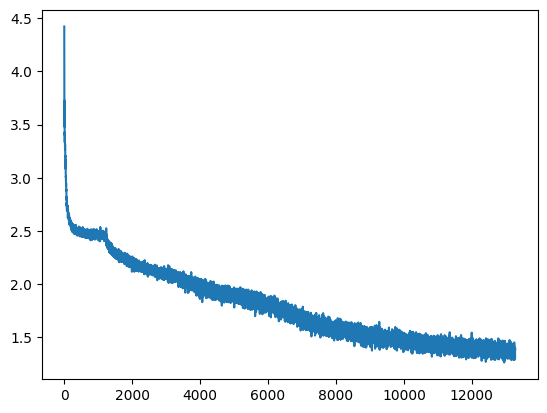

In [73]:
from matplotlib import pyplot as plt
plt.plot(losses)

In [74]:
@torch.no_grad()
def eval_ce_aligned(mmap_file, n_batches=200):
    model.eval()
    T = block_size
    pad_len = 0#int(getattr(model.config, "phase_pad_len", 0))
    losses = []
    N = len(mmap_file)
    # need pad_len + T + 1 tokens for X and Y when prefix comes from data
    lo = pad_len
    hi = N - T - 2
    for _ in range(n_batches):
        start = np.random.randint(lo, hi)
        x_all = np.array(mmap_file[start - pad_len:start + T], dtype=np.int64)      # [pad_len+T]
        y_vis = np.array(mmap_file[start + 1:start + 1 + T], dtype=np.int64)        # [T]
        X = torch.from_numpy(x_all).unsqueeze(0).to(device)
        Y = torch.from_numpy(y_vis).unsqueeze(0).to(device)
        _, loss = model(X, Y)
        losses.append(loss.item())
    return float(np.mean(losses))

print("val   CE:", eval_ce_aligned(val_ids,   n_batches=200))

val   CE: 1.6569630414247514


In [75]:
PATH = "my_model.pth"

# Save the model's state_dict
torch.save(model.state_dict(), PATH)

In [83]:
import pickle
def decode_chars(token_ids, itos):
    """
    Decodes a list of character token IDs into a string.
    """
    return ''.join([itos[i] for i in token_ids])

def encode_chars(text, stoi):
    """
    Encodes a string into a list of token IDs, one per character.
    """
    return [stoi.get(c, 0) for c in text]


def decode_sequence_char(
    model, stoi, itos, prompt, max_new_tokens=100, block_size=256,
    use_fenchel=False, tau=1.0, fenchel_iters=3, temperature=1.0
):
    model.eval()
    device = next(model.parameters()).device

    max_ctx = int(block_size)

    # ?1 assume space token exists; fallback to 0 if missing
    space_id = stoi.get(' ', 0)

    # encode prompt
    start_ids = torch.tensor([encode_chars(prompt, stoi)], dtype=torch.long, device=device)

    # prepend the pad once; from now on the window just slides

    idx = start_ids

    for _ in range(max_new_tokens):
        context = idx[:, -max_ctx:]  # rotating buffer: last pad_len+block_size tokens
        logits, _ = model(context, None)
        last_logits = logits[:, -1, :]
        probs = torch.softmax(last_logits / temperature, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
        idx = torch.cat([idx, next_token], dim=1)

    # drop the initial pad when returning the string
    out_tokens = idx[0].tolist()
    return decode_chars(out_tokens, itos)
with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi = meta["stoi"]
itos = meta["itos"]

prompt = " "
generated = decode_sequence_char(
    model=model,
    stoi=stoi,
    itos=itos,
    prompt=prompt,
    max_new_tokens=1024,
    block_size=1024,
    use_fenchel=False,
    tau=1.5,
    fenchel_iters=2,
    temperature=0.01
)

print(generated)


 the hath he have him to him his head
him his he his he his he his he his he his he his he his he his he his he his helpess he his helpess
he his he his he his he his he his he his he had he his he his he his he his helf he deses he deses helf helf
he deperated his deperated his deperated his deperated his deperated
at his his his his deperated his his deperated his deperated his deperated hiself
ators his his his deperated his his deperated his deperated his deperated his deperated
ators his his his deperated his his deperated his deperated his deperated his his deperated
ators his his deperated his depering his deperated his deperated his deperated
ators his his depering his depering his depering his depering his depering his deperated
atones his depering his depering his depering his depering his depering his deather
atones his depering his depering his depering his depering his deathers his deather
atones his depering himses his depering his depering his deathers his deathers his d

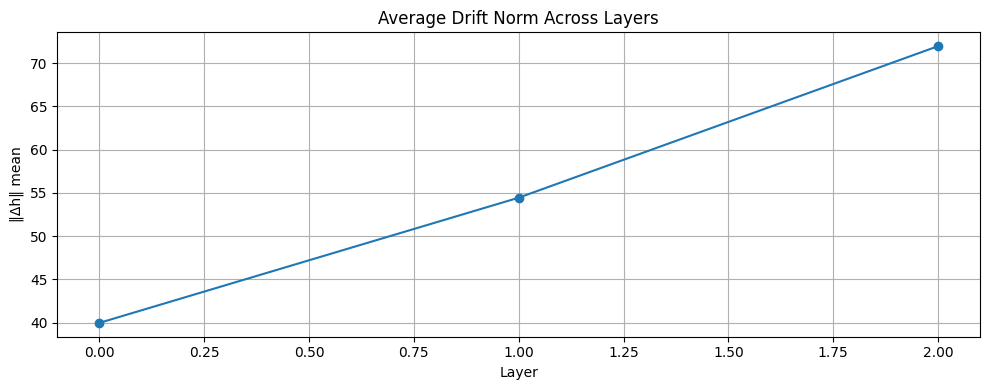

Jacobian rank (final token, projected): 66


In [84]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import grad


@torch.no_grad()
def compute_drift_trajectories(model, idx, pad_token_id=None):
    """
    Drift vectors Δh_l = h_{l+1} - h_l aligned to the shrinking time axis.
    idx: [B, T_visible]
    pad_token_id: pad token id to prepend once (?1 default=0 if None)
    returns: list of arrays, one per layer-gap, each shaped [B]
    """
    model.train()
    device = idx.device
    B, T_vis = idx.size()

    tok = idx

    # token + pos emb
    pos = torch.arange(0, tok.size(1), dtype=torch.long, device=device)
    tok_emb = model.tok_emb(tok)
    x = tok_emb   # [B, T_all, C]

    layers = []
    with torch.no_grad():
        for block in model.blocks:
            x ,_= block(x)             # time shrinks by n_head each block (per your setup)
            layers.append(x.clone()) # store aligned outputs

    # compute drifts with alignment: previous tail matches current length
    drifts = []
    for i in range(len(layers) - 1):
        a = layers[i]
        b = layers[i + 1]
        a_aligned = a[:, -b.size(1):, :]
        d = (b - a_aligned)
        drifts.append(d.norm(dim=-1).mean(dim=-1).cpu().numpy())  # [B]
    return drifts


def compute_jacobian_rank(model, idx, projection_dim=324, pad_token_id=None):
    """
    Rank of Jacobian d logits_proj(T_final) / d emb(T_input_last) with pad-once and shrink.
    idx: [B, T_visible]
    pad_token_id: pad token id to prepend once (?2 default=0 if None)
    """
    model.train()
    device = idx.device
    B, T_vis = idx.size()

    tok = idx

    # embeddings with grad
    pos = torch.arange(0, tok.size(1), dtype=torch.long, device=device)
    tok_emb = model.tok_emb(tok)
    emb = (tok_emb).requires_grad_(True)

    def forward_emb(emb_input):
        x = emb_input
        for block in model.blocks:
            x ,_= block(x)             # time shrinks each block
        logits = model.lm_head(x)    # [B, T_out, V]
        return logits[:, -1, :projection_dim]  # final token after shrink, projected

    output = forward_emb(emb)         # [B, P]
    jac_rows = []
    for i in range(output.shape[-1]):
        go = torch.zeros_like(output)
        go[:, i] = 1.0
        gi = grad(output, emb, grad_outputs=go, retain_graph=True)[0]  # [B, T_all, C]
        jac_rows.append(gi[:, -1, :].detach().cpu().numpy().squeeze()) # grad w.r.t. last input step
    J = np.stack(jac_rows, axis=0)     # [P, C]
    return int(np.linalg.matrix_rank(J))

def plot_drift(drift_norms):
    """
    Plot average drift norm per layer.
    """
    plt.figure(figsize=(10, 4))
    plt.plot([np.mean(d) for d in drift_norms], marker='o')
    plt.title("Average Drift Norm Across Layers")
    plt.xlabel("Layer")
    plt.ylabel("‖Δh‖ mean")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example usage
input_ids = torch.randint(0, model.vocab_size, (1, 512)).to(device)

jac_rank = compute_jacobian_rank(model, input_ids)

drift_norms = compute_drift_trajectories(model, input_ids)
plot_drift(drift_norms)

print("Jacobian rank (final token, projected):", jac_rank)


In [85]:
import torch
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def collect_drift_matrix(model, idx, pad_token_id=None):
    """
    Build a drift matrix by stacking aligned per-layer deltas:
      Δ_l = h_{l+1} - tail_match(h_l)
    Tail-match aligns time since each block trims from the left.

    idx: [B, T_visible]
    pad_token_id: ?1 left-pad token id; default 0 if None
    returns: torch.FloatTensor [N, D] on CPU where N = sum_l B * T_l
    """
    model.train()
    device = idx.device
    B, T_vis = idx.size()

    tok = idx

    # 2) embed like forward() does
    pos = torch.arange(0, tok.size(1), dtype=torch.long, device=device)
    pos_emb = model.pos_emb(pos)  # [T_all, C]
    tok_emb = model.tok_emb(tok)
    x = tok_emb + pos_emb

    # 3) collect per-block states (time shrinks each block)
    states = []
    with torch.no_grad():
        for block in model.blocks:
            x ,_= block(x)     # length shrinks by your per-layer trim
            states.append(x.clone())

    # 4) aligned drifts: match tail of h_l to h_{l+1}
    drift_chunks = []
    for i in range(len(states) - 1):
        a = states[i]       # [B, T_a, C]
        b = states[i + 1]   # [B, T_b, C], T_b <= T_a
        a_aligned = a[:, -b.size(1):, :]     # tail-match
        d = (b - a_aligned).reshape(-1, b.size(-1))  # [B*T_b, C]
        drift_chunks.append(d.cpu())

    drift_matrix = torch.cat(drift_chunks, dim=0) if drift_chunks else torch.empty(0, tok_emb.size(-1))
    return drift_matrix  # [N, D] on CPU


def run_drift_pca(drift_matrix, k=40):
    """
    PCA on drift samples. drift_matrix can be torch.Tensor [N, D] (CPU or CUDA) or np.ndarray.
    """
    if isinstance(drift_matrix, torch.Tensor):
        drift_np = drift_matrix.detach().cpu().numpy()
    else:
        drift_np = np.asarray(drift_matrix)
    k = min(k, drift_np.shape[0], drift_np.shape[1])  # guard
    pca = PCA(n_components=k)
    pca.fit(drift_np)
    explained = pca.explained_variance_ratio_
    return explained, pca


def plot_explained_variance(explained):
    plt.figure(figsize=(8, 4))
    plt.plot(np.cumsum(explained) * 100, marker='o')
    plt.xlabel("Principal Component")
    plt.ylabel("Cumulative Variance Explained (%)")
    plt.title("Drift Trajectory PCA: Explained Variance")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [86]:
from sklearn.mixture import GaussianMixture
import seaborn as sns

def get_projected_residuals(drift_matrix, pca):
    """
    Project Δh onto PCA space and get residuals.
    """
    proj = pca.transform(drift_matrix.numpy())
    recon = pca.inverse_transform(proj)
    residuals = drift_matrix.numpy() - recon
    return proj, residuals

def fit_gmm(proj_data, k=4):
    """
    Fit GMM to PCA-projected drift vectors to identify latent regimes.
    """
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=0)
    gmm.fit(proj_data)
    labels = gmm.predict(proj_data)
    return gmm, labels

def plot_gmm_clusters(proj_data, labels):
    """
    Plot GMM clustering over first 2 PCA components.
    """
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=proj_data[:, 0], y=proj_data[:, 1], hue=labels, palette="tab10", s=10)
    plt.title("Latent Regimes from Drift PCA (GMM Clusters)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


/Users/joshuahkuttenkuler/miniforge3/lib/python3.12/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/joshuahkuttenkuler/miniforge3/lib/python3.12/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/joshuahkuttenkuler/miniforge3/lib/python3.12/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/joshuahkuttenkuler/miniforge3/lib/python3.12/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/joshuahkuttenkuler/miniforge3/lib/python3.12/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/joshuahkuttenkuler/miniforge3/lib/python3.12/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: invalid value enc

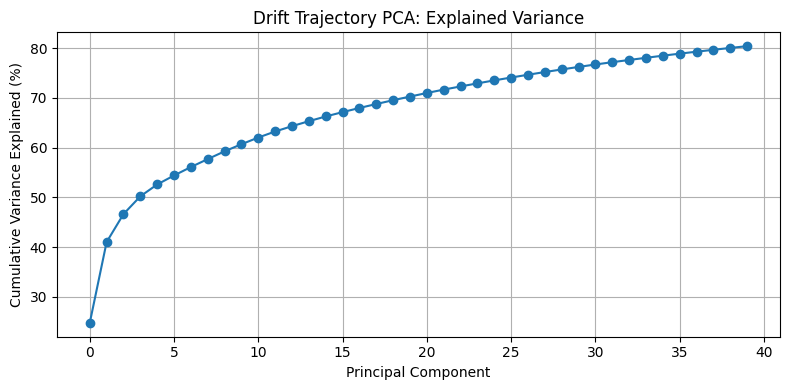

/Users/joshuahkuttenkuler/miniforge3/lib/python3.12/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/joshuahkuttenkuler/miniforge3/lib/python3.12/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/joshuahkuttenkuler/miniforge3/lib/python3.12/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/joshuahkuttenkuler/miniforge3/lib/python3.12/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: divide by zero encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (1, -1)) @ self.components_.T
/Users/joshuahkuttenkuler/miniforge3/lib/python3.12/site-packages/sklearn/decomposition/_base.py:155: RuntimeWarning: overflow encountered in matmul
  X_transformed -= xp.reshape(self.mean_, (

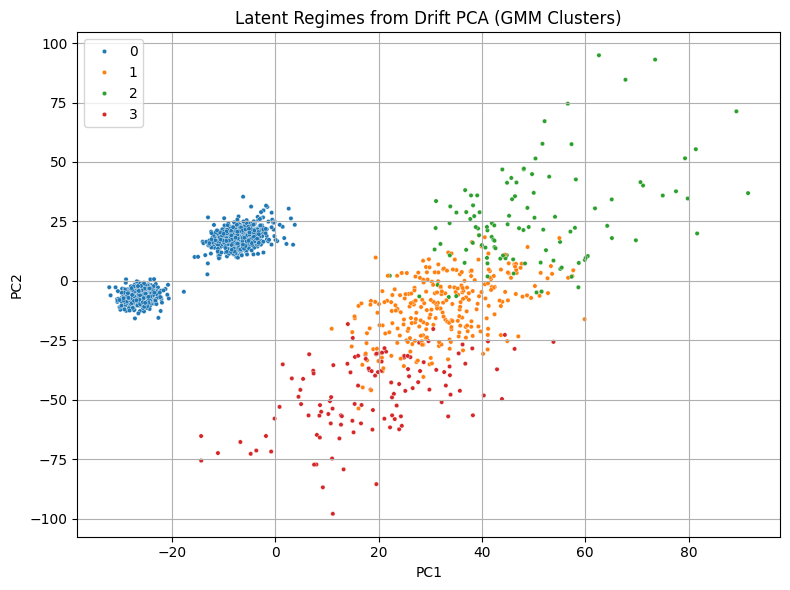

In [87]:
# Inputs
input_ids = torch.randint(0, model.vocab_size, (1, 512)).to(device)

# Drift matrix
drift_matrix = collect_drift_matrix(model, input_ids)

# PCA and variance
explained, pca = run_drift_pca(drift_matrix, k=40)
plot_explained_variance(explained)

# Residuals and GMM regime fit
proj, residuals = get_projected_residuals(drift_matrix, pca)
gmm, labels = fit_gmm(proj, k=4)
plot_gmm_clusters(proj, labels)



🔍 Probe: ['why', 'what', 'where', 'when'] vs who


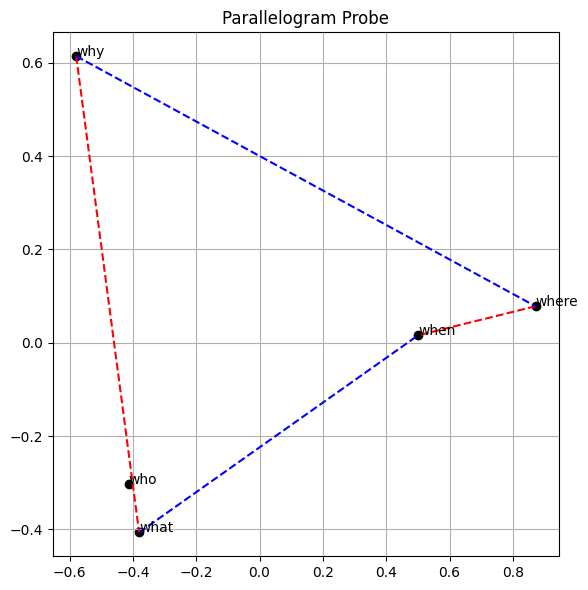


🔍 Probe: ['prepare', 'begin', 'cease', 'end'] vs remain


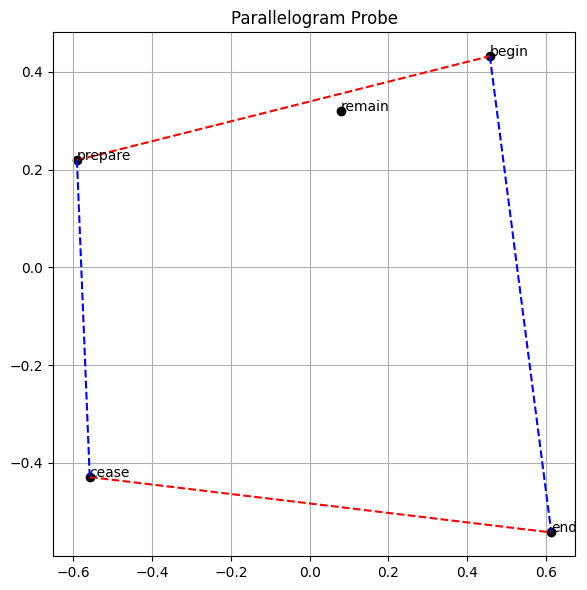


🔍 Probe: ['happy', 'sad', 'disagreeable', 'willing'] vs afraid


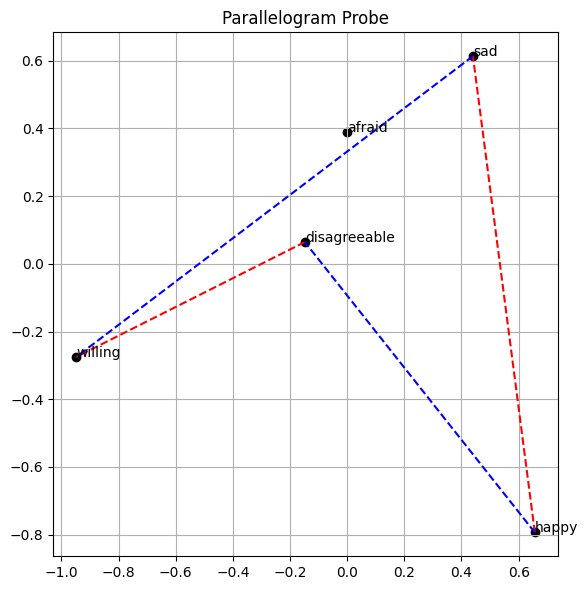


🔍 Probe: ['king', 'queen', 'man', 'woman'] vs apple


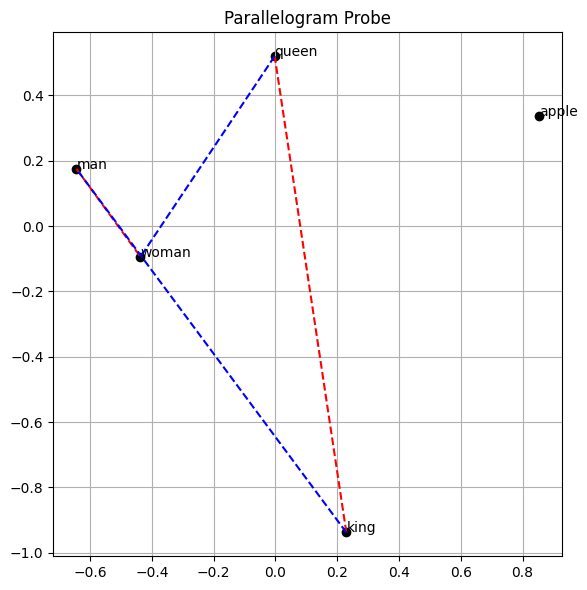


🔍 Probe: ['king', 'knight', 'man', 'maiden'] vs book


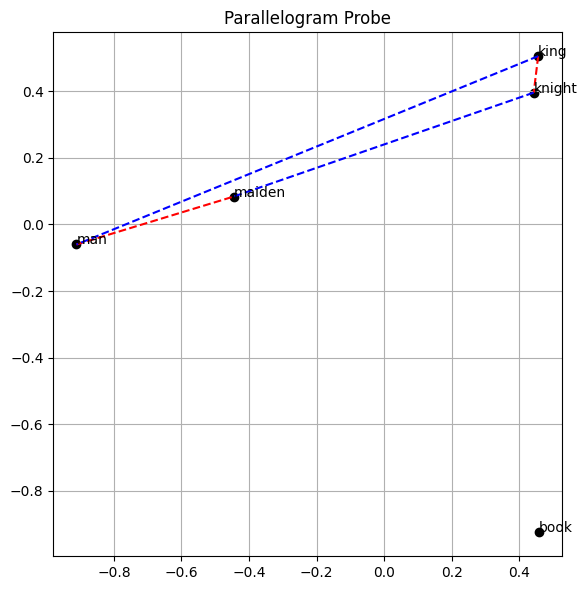


🔍 Probe: ['to', 'from', 'in', 'out'] vs the


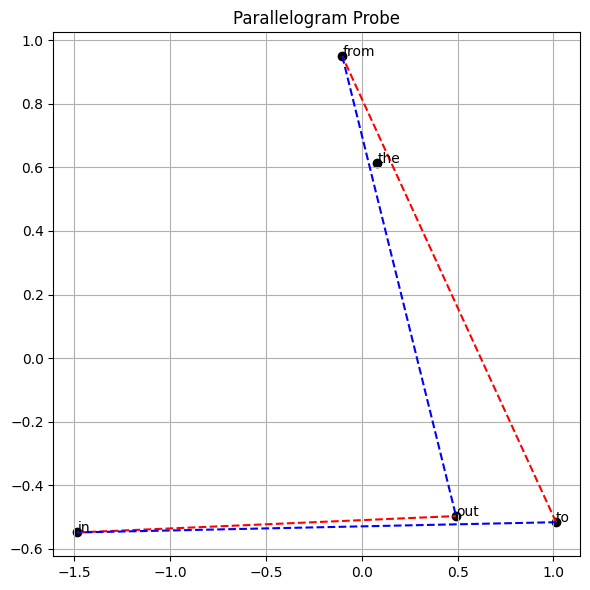

In [ ]:
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# === Load vocab ===
with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)

stoi = meta["stoi"]
itos = meta["itos"]
device = next(model.parameters()).device
wte = model.tok_emb

# === Char embedding extractor ===
def get_char_embedding(word):
    ids = [stoi[c] for c in word if c in stoi]
    if not ids:
        return None
    with torch.no_grad():
        emb = model.tok_emb(torch.tensor(ids, dtype=torch.long, device=device)).unsqueeze(0)
        #emb = torch.cat(model.transformer.wte(torch.tensor(ids, dtype=torch.long, device=device)).unsqueeze(0), dim=-1)
        return emb.mean(dim=1).squeeze(0).cpu().numpy()

# === Plot one parallelogram ===
def plot_parallelogram(words, outlier=None):
    vecs = [get_char_embedding(w) for w in words]
    labels = words.copy()
    if outlier:
        vecs.append(get_char_embedding(outlier))
        labels.append(outlier)

    # drop None values
    vecs = [v for v in vecs if v is not None]
    if len(vecs) < 4:
        print(f"⚠️ Not enough valid embeddings for: {labels}")
        return

    vecs = np.stack(vecs)
    proj = PCA(n_components=2).fit_transform(vecs)

    plt.figure(figsize=(6, 6))
    plt.scatter(proj[:, 0], proj[:, 1], color='black')
    for i, label in enumerate(labels):
        plt.text(proj[i, 0], proj[i, 1], label, fontsize=10)

    if len(proj) >= 4:
        A, B, C, D = proj[:4]
        plt.plot([A[0], B[0]], [A[1], B[1]], 'r--')
        plt.plot([C[0], D[0]], [C[1], D[1]], 'r--')
        plt.plot([A[0], C[0]], [A[1], C[1]], 'b--')
        plt.plot([B[0], D[0]], [B[1], D[1]], 'b--')

    plt.title("Parallelogram Probe")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === Define test sets ===
test_sets = [
    (["why", "what", "where", "when"], "who"),               # verb→third person
    (["prepare", "begin", "cease", "end"], "remain"),               # singular→plural
    (["happy", "sad", "disagreeable", "willing"], "afraid"),       # negation prefix
    (["king", "queen", "man", "woman"], "apple"),            # gender pairs
    (["king", "knight", "man", "maiden"], "book"),
    (["to", "from", "in", "out"], "the"),                    # function-word symmetry
]

# === Run all probes ===
for words, outlier in test_sets:
    print(f"\n🔍 Probe: {words} vs {outlier}")
    plot_parallelogram(words, outlier)


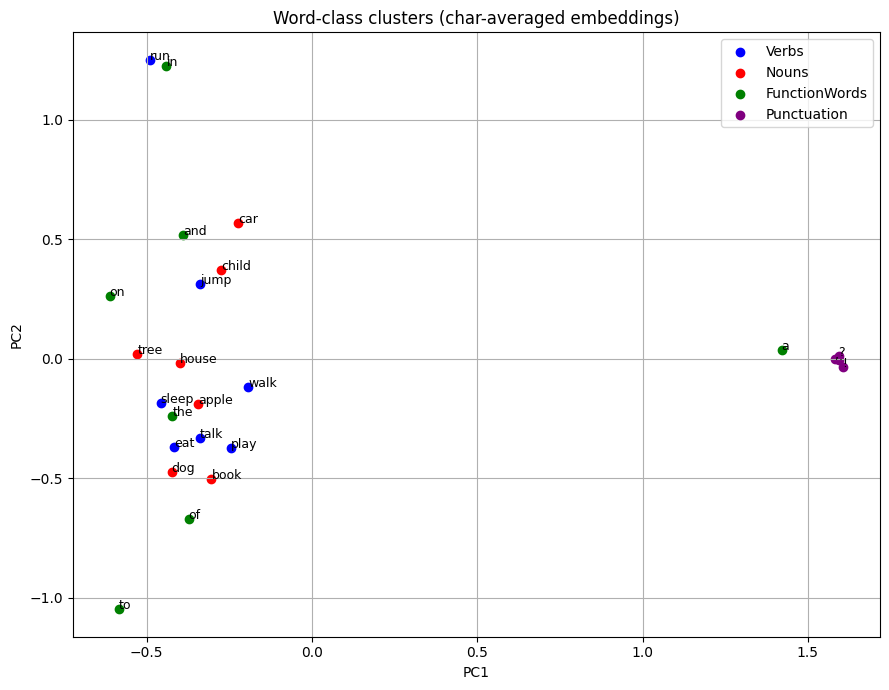

In [ ]:
import torch, pickle, matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# ---------- load vocab ----------
with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi, itos = meta["stoi"], meta["itos"]

# ---------- model bits ----------
device = next(model.parameters()).device
model.eval()                      # <— turn off dropout everywhere
wte = model.tok_emb
wte.eval()

@torch.no_grad()
def get_char_embedding(word):
    ids = [stoi[c] for c in word if c in stoi]
    if len(ids) < 2:              # ← need ≥2 chars for HailFire geometry
        return None
    with torch.no_grad():
        t = torch.tensor(ids, device=device).unsqueeze(0)      # [1, T]
        emb = model.tok_emb(t).mean(dim=1).squeeze(0)                    # (d,)
        return emb.cpu().numpy()

# ---------- categories ----------
categories = {
    "Verbs":        ["play","run","eat","sleep","jump","talk","walk"],
    "Nouns":        ["dog","tree","car","book","child","house","apple"],
    "FunctionWords":["the","and","in","on","to","of","a   "],
    "Punctuation":  [".    ",",    ","!    ","?    "],
}

# ---------- gather ----------
vecs, labels, words = [], [], []
for cat, wl in categories.items():
    for w in wl:
        v = get_char_embedding(w)
        if v is not None:
            vecs.append(v)
            labels.append(cat)
            words.append(w)

vecs = np.stack(vecs)             # ← now guaranteed rectangular

# ---------- PCA ----------
proj = PCA(n_components=2).fit_transform(vecs)

# ---------- plot ----------
colors = dict(Verbs="blue", Nouns="red",
              FunctionWords="green", Punctuation="purple")

plt.figure(figsize=(9,7))
for cat in categories:
    idx = [i for i,l in enumerate(labels) if l==cat]
    plt.scatter(proj[idx,0], proj[idx,1], label=cat, color=colors[cat])
    for i in idx:
        plt.text(proj[i,0], proj[i,1], words[i], fontsize=9)

plt.title("Word-class clusters (char-averaged embeddings)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()


In [ ]:
file_path = 'simple_model.pth'

# 3. Save the model's state_dict
torch.save(model.state_dict(), file_path)